In [17]:
%reload_ext autoreload
%autoreload 2

In [18]:
## -----------IMPORT LIBRARIES
import pandas as pd #for dealing with csv import
import os # for joining paths and filenames sensibly
import numpy as np #for the population std
import glob # for finding csv data Çfiles
import platform # paths use different dividers on linux vs windows, so we need to test for this
import csv
import seaborn as sns
import matplotlib.pyplot as plt

#from linares_plot import *

In [19]:
#path_folder = 'C:\\Users\\david\\Downloads\\monturiol'
path_folder = 'C:\\Users\\david\\Downloads\\sample_data'


In [20]:
search_string=os.path.join(path_folder,'*.csv') 
## -----------LOAD DATA
files = glob.glob(search_string) #list of data files in the named location
files

['C:\\Users\\david\\Downloads\\sample_data\\874026_tarea_iceberg_2025-05-06_19h53.39.623.csv',
 'C:\\Users\\david\\Downloads\\sample_data\\david_tarea_iceberg_2025-05-06_19h44.04.622.csv',
 'C:\\Users\\david\\Downloads\\sample_data\\ester_tarea_iceberg_2025-05-07_08h08.56.238.csv']

In [21]:
all_subjects = []

for filename in files:
    subject =filename.split('\\')[-1].split('_')[0]
    df = pd.read_csv(filename)
    
    frames=[]
    # control
    rts = df['resp_control.rt'].dropna().values
    df_control = pd.DataFrame({ 'reaction time': rts, 'condition': ['control'] * len(rts) })
    frames.append(df_control)
    
    # instrumental
    rts = df['resp_inst.rt'].dropna().values
    df_inst = pd.DataFrame({ 'reaction time': rts, 'condition': ['instrumental'] * len(rts) })
    frames.append(df_inst)
    
    # lyrics
    rts = df['resp_lyrics.rt'].dropna().values
    df_lyrics = pd.DataFrame({ 'reaction time': rts, 'condition': ['lyrics'] * len(rts) })
    frames.append(df_lyrics)
    
    # multitasking
    rts = df['resp_musicv_r1.rt'].dropna().values
    df_multitasking= pd.DataFrame({ 'reaction time': rts, 'condition': ['multitasking'] * len(rts) })
    frames.append(df_multitasking)
    
    ## concatenate
    df_subject = pd.concat(frames, ignore_index=True)
    df_subject['subject'] = subject
    all_subjects.append(df_subject)
    #
#
#

df = pd.concat(all_subjects, ignore_index=True)  
    

C:\Users\david\AppData\Local\Temp\ipykernel_16564\2257528996.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


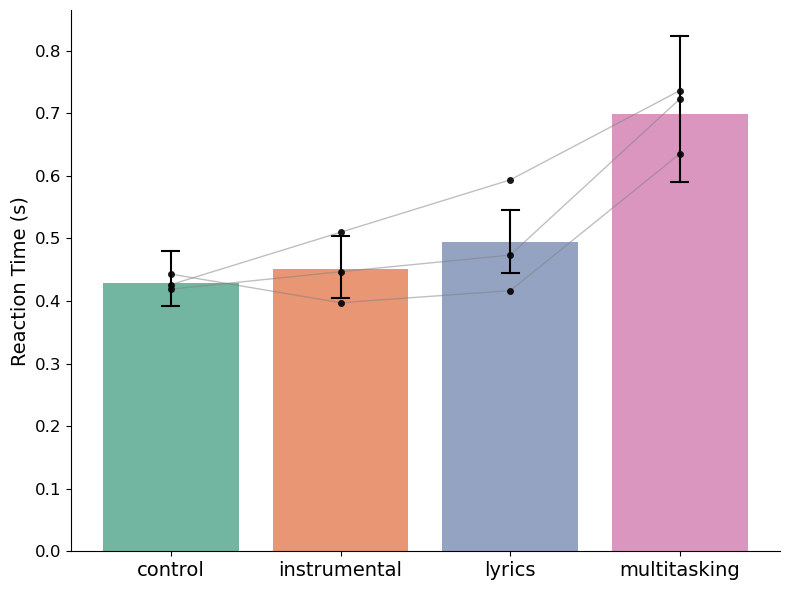

In [22]:


# Paleta personalizada para las condiciones
palette = sns.color_palette("Set2", df['condition'].nunique())

plt.figure(figsize=(8, 6))

# Barra con media y error (CI 95%), usando colores distintos
sns.barplot(
    data=df,
    x='condition',
    y='reaction time',
    ci=95,
    errcolor='black',
    errwidth=1.5,
    capsize=0.1,
    palette=palette
)

# Calcular la media por sujeto y condición
subject_means = df.groupby(['subject', 'condition'])['reaction time'].mean().reset_index()

# Puntos por sujeto
sns.stripplot(
    data=subject_means,
    x='condition',
    y='reaction time',
    color='black',
    jitter=False,
    size=5,
    alpha=0.9
)

# Conectar puntos por sujeto
for subject, group in subject_means.groupby('subject'):
    sorted_group = group.sort_values('condition')
    plt.plot(
        sorted_group['condition'],
        sorted_group['reaction time'],
        color='gray',
        alpha=0.5,
        linewidth=1
    )

# Estética
sns.despine()  # Quitar ejes superior y derecho
plt.xticks(rotation=0, fontsize=14)  # Inclinación y tamaño de etiquetas X
plt.yticks(fontsize=12)  # Tamaño de etiquetas Y
plt.ylabel('Reaction Time (s)', fontsize=14)
plt.xlabel('')
plt.title('', fontsize=12)
plt.tight_layout()
plt.show()


In [23]:
#Estadística

In [24]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "Q('reaction time') ~ condition",  # Condición como efecto fijo
    data=df,
    groups=df["subject"]               # Sujeto como efecto aleatorio
)
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Q('reaction time')
No. Observations:  120      Method:              REML              
No. Groups:        3        Scale:               0.0406            
Min. group size:   40       Log-Likelihood:      13.6577           
Max. group size:   40       Converged:           Yes               
Mean group size:   40.0                                            
-------------------------------------------------------------------
                          Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.429    0.042 10.279 0.000  0.347  0.511
condition[T.instrumental] 0.022    0.052  0.421 0.674 -0.080  0.124
condition[T.lyrics]       0.065    0.052  1.251 0.211 -0.037  0.167
condition[T.multitasking] 0.269    0.052  5.166 0.000  0.167  0.371
Group Var                 0.001    0.011                       

C:\Users\david\anaconda3\envs\python3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
from statsmodels.stats.anova import AnovaRM

df_agg = df.groupby(['subject', 'condition'])['reaction time'].mean().reset_index()

anova = AnovaRM(
    data=df_agg,
    depvar='reaction time',
    subject='subject',
    within=['condition']
).fit()

print(anova)



                Anova
          F Value Num DF Den DF Pr > F
--------------------------------------
condition 23.6148 3.0000 6.0000 0.0010



In [26]:
import pingouin as pg

# Realizar las comparaciones post-hoc con t-tests
posthoc = pg.pairwise_ttests(
    data=df,
    dv='reaction time',
    within='condition',
    subject='subject',
    padjust='fdr_bh'  # Corrección por FDR (Benjamini-Hochberg)
)

# Imprimir las columnas relevantes (comparaciones, p-corr, etc.)
print(posthoc[['A', 'B', 'T', 'p-corr']])


              A             B          T    p-corr
0       control  instrumental  -0.584519  0.618024
1       control        lyrics  -1.158044  0.439737
2       control  multitasking  -7.023789  0.046880
3  instrumental        lyrics  -2.120042  0.252156
4  instrumental  multitasking -16.461350  0.022020
5        lyrics  multitasking  -6.416256  0.046880


C:\Users\david\anaconda3\envs\python3\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
C:\Users\david\anaconda3\envs\python3\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
C:\Users\david\anaconda3\envs\python3\lib\site-packages\scipy\stats\_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
C:\Users\david\anaconda3\envs\python3\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
C:\Users\david\anaconda3\envs\python3\lib\site-packages\scipy\stats\_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  retur

C:\Users\david\AppData\Local\Temp\ipykernel_16564\4260836433.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  barplot = sns.barplot(


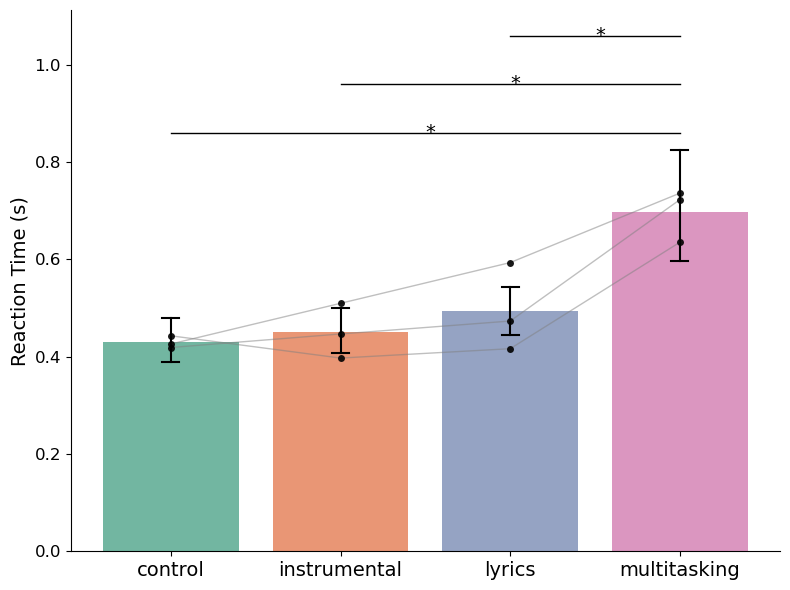

In [27]:
# Paleta personalizada para las condiciones
palette = sns.color_palette("Set2", df['condition'].nunique())

plt.figure(figsize=(8, 6))

# Barra con media y error (CI 95%), usando colores distintos
barplot = sns.barplot(
    data=df,
    x='condition',
    y='reaction time',
    ci=95,
    errcolor='black',
    errwidth=1.5,
    capsize=0.1,
    palette=palette
)

# Calcular la media por sujeto y condición
subject_means = df.groupby(['subject', 'condition'])['reaction time'].mean().reset_index()

# Puntos por sujeto
sns.stripplot(
    data=subject_means,
    x='condition',
    y='reaction time',
    color='black',
    jitter=False,
    size=5,
    alpha=0.9
)

# Conectar puntos por sujeto
for subject, group in subject_means.groupby('subject'):
    sorted_group = group.sort_values('condition')
    plt.plot(
        sorted_group['condition'],
        sorted_group['reaction time'],
        color='gray',
        alpha=0.5,
        linewidth=1
    )


# Añadir líneas de comparación con asteriscos
std_dev = df['reaction time'].std()  # Desviación estándar de los datos

y_max = df['reaction time'].mean() + 1.5*std_dev   # Comenzamos con 1 std del r_t
y_offset = 0.1  # incremento de altura de cada nueva comparación


for i, row in posthoc.iterrows():
    condition_1 = row['A']
    condition_2 = row['B']
    p_value = row['p-corr']
    
    # Verificar si la comparación es significativa
    if p_value < 0.05:
        star = '*' if p_value < 0.05 else '**' if p_value < 0.01 else '***'
        
        # Obtener las posiciones de las barras en el gráfico
        x1_pos = barplot.get_xticks()[list(df['condition'].unique()).index(condition_1)]
        x2_pos = barplot.get_xticks()[list(df['condition'].unique()).index(condition_2)]
        
        # Dibujar línea horizontal conectando los centros de las barras
        plt.plot([x1_pos, x2_pos], [y_max, y_max], color='black', lw=1)
        # Colocar asterisco en el medio de la línea
        plt.text((x1_pos + x2_pos) / 2, y_max-0.01, star, fontsize=14, color='black')
        #print(y_max)
        # Incrementamos la altura de la línea de comparación para evitar solapamientos
        y_max += y_offset  # Aumentamos el valor de y_max para la siguiente línea de comparación
        

# Estética
sns.despine()  # Quitar ejes superior y derecho
plt.xticks(rotation=0, fontsize=14)  # Inclinación y tamaño de etiquetas X
plt.yticks(fontsize=12)  # Tamaño de etiquetas Y
plt.ylabel('Reaction Time (s)', fontsize=14)
plt.xlabel('')
plt.title('', fontsize=12)
plt.tight_layout()


filename='reaction_times_iceberg_puntos.png'
save_path = os.path.join(os.getcwd(), filename)
# Guardar con fondo transparente
plt.savefig(save_path, transparent=True)

plt.show()


C:\Users\david\AppData\Local\Temp\ipykernel_16564\3450420900.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  barplot = sns.barplot(


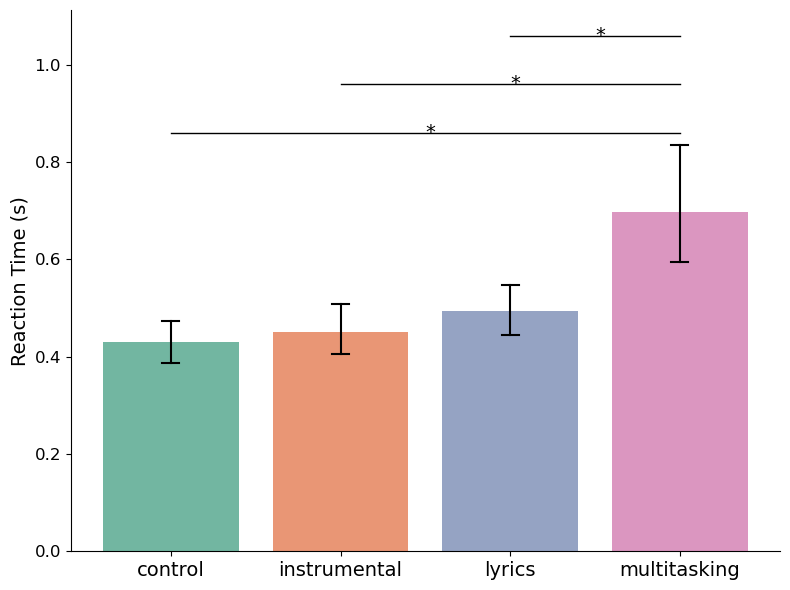

In [28]:
# Paleta personalizada para las condiciones
palette = sns.color_palette("Set2", df['condition'].nunique())

plt.figure(figsize=(8, 6))

# Barra con media y error (CI 95%), usando colores distintos
barplot = sns.barplot(
    data=df,
    x='condition',
    y='reaction time',
    ci=95,
    errcolor='black',
    errwidth=1.5,
    capsize=0.1,
    palette=palette
)


# Añadir líneas de comparación con asteriscos
std_dev = df['reaction time'].std()  # Desviación estándar de los datos

y_max = df['reaction time'].mean() + 1.5*std_dev   # Comenzamos con 1 std del r_t
y_offset = 0.1  # incremento de altura de cada nueva comparación


for i, row in posthoc.iterrows():
    condition_1 = row['A']
    condition_2 = row['B']
    p_value = row['p-corr']
    
    # Verificar si la comparación es significativa
    if p_value < 0.05:
        star = '*' if p_value < 0.05 else '**' if p_value < 0.01 else '***'
        
        # Obtener las posiciones de las barras en el gráfico
        x1_pos = barplot.get_xticks()[list(df['condition'].unique()).index(condition_1)]
        x2_pos = barplot.get_xticks()[list(df['condition'].unique()).index(condition_2)]
        
        # Dibujar línea horizontal conectando los centros de las barras
        plt.plot([x1_pos, x2_pos], [y_max, y_max], color='black', lw=1)
        # Colocar asterisco en el medio de la línea
        plt.text((x1_pos + x2_pos) / 2, y_max-0.01, star, fontsize=14, color='black')
        #print(y_max)
        # Incrementamos la altura de la línea de comparación para evitar solapamientos
        y_max += y_offset  # Aumentamos el valor de y_max para la siguiente línea de comparación
        

# Estética
sns.despine()  # Quitar ejes superior y derecho
plt.xticks(rotation=0, fontsize=14)  # Inclinación y tamaño de etiquetas X
plt.yticks(fontsize=12)  # Tamaño de etiquetas Y
plt.ylabel('Reaction Time (s)', fontsize=14)
plt.xlabel('')
plt.title('', fontsize=12)
plt.tight_layout()


filename='reaction_times_iceberg.png'
save_path = os.path.join(os.getcwd(), filename)
# Guardar con fondo transparente
plt.savefig(save_path, transparent=True)

plt.show()